> #  ** Graficas **

---

 

In [ ]:
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import random
import nltk
import matplotlib.pyplot as plt 
import pandas as pd
import json
from tabulate import tabulate 
from collections import Counter

Primera visualizacion

In [1]:
with open('datos/datos_crudos.json', 'r') as file_1:
    json_res: dict = json.loads(file_1.read(),strict=False)
corpus = pd.DataFrame(json_res)

tab = corpus.describe().copy()
tab.iloc[2].iloc[0] = (tab.iloc[2].iloc[0])[0:50] + "..."
tab.iloc[2].iloc[2] = (tab.iloc[2].iloc[2])[0:50] + "..."
print(tabulate(tab, headers='keys', tablefmt='outlin:e'))

tab = corpus.head().copy()
for col in tab.index:
    tab.iloc[col].iloc[0]=tab.iloc[col].iloc[0][0:50] + "..."
    tab.iloc[col].iloc[2]=tab.iloc[col].iloc[2][0:50] + "..."
print(tabulate(tab, headers='keys', tablefmt='outline'))

        Título                                                 Fecha       Contenido
------  -----------------------------------------------------  ----------  -----------------------------------------------------
count   3340                                                   3340        3340
unique  3338                                                   334         3339
top     Presidente reporta pormenores del sismo de 6.9; do...  13.07.2023  2022: Año de Ricardo Flores Magón, precursor de la...
freq    2                                                      10          2
+----+-------------------------------------------------------+------------+-------------------------------------------------------+
|    | Título                                                | Fecha      | Contenido                                             |
+====+=======================================================+============+=======================================================+
|  0 | Presidente llama 

Graficas de estadisticas

In [2]:
#=========> Eliminando la leyenda inicial,duplicados y vacios
muestra = corpus.copy()

funContar = lambda x: len (x.split())
quitarLeyendas = lambda x: re.sub(r"^(.*?)\d{1,2}\/\d{1,2}\/\d{1,4}","",x,1)

muestra.Contenido = muestra.Contenido.apply(quitarLeyendas)
muestra = muestra.drop_duplicates(subset=["Contenido"]) 

muestra_contenido= muestra.Contenido
cantidad_palabras = muestra_contenido.apply(funContar)
muestra = muestra[cantidad_palabras > 3 ]


#=========> Conteo de palabras en contenido
muestra_contenido= muestra.Contenido
cantidad_palabras = muestra_contenido.apply(funContar)
des_palabras=(pd.DataFrame(cantidad_palabras.describe()))
print(tabulate(des_palabras, headers='keys', tablefmt='outline'))


#=========> Conteo de palabras en contenido
muestra_titulo= muestra.Título
titulo_palabras = muestra_titulo.apply(funContar)
des_titulos=(pd.DataFrame(titulo_palabras.describe()))
print(tabulate(des_titulos, headers='keys', tablefmt='outline'))

#=========> Descripcion del datetime
str_to_date = lambda x: datetime.strptime(x, '%d.%m.%Y')
muestra_fechas = muestra.Fecha
fechas_obj = muestra_fechas.apply(str_to_date)
des_fechas=(pd.DataFrame(fechas_obj.describe()))

print(tabulate(des_fechas, headers='keys', tablefmt='outline'))

+-------+-------------+
|       |   Contenido |
+=======+=============+
| count |    3332     |
| mean  |     471.633 |
| std   |     521.759 |
| min   |       5     |
| 25%   |     256     |
| 50%   |     403     |
| 75%   |     560     |
| max   |    8631     |
+-------+-------------+
+-------+------------+
|       |     Título |
+=======+============+
| count | 3332       |
| mean  |   13.7263  |
| std   |    3.79742 |
| min   |    2       |
| 25%   |   11       |
| 50%   |   14       |
| 75%   |   16       |
| max   |   30       |
+-------+------------+
+-------+----------------------------+
|       | Fecha                      |
+=======+============================+
| count | 3332                       |
| mean  | 2021-05-02 11:36:39.759904 |
| min   | 2018-12-04 00:00:00        |
| 25%   | 2020-01-25 00:00:00        |
| 50%   | 2021-05-16 12:00:00        |
| 75%   | 2022-08-11 00:00:00        |
| max   | 2023-07-13 00:00:00        |
+-------+----------------------------+


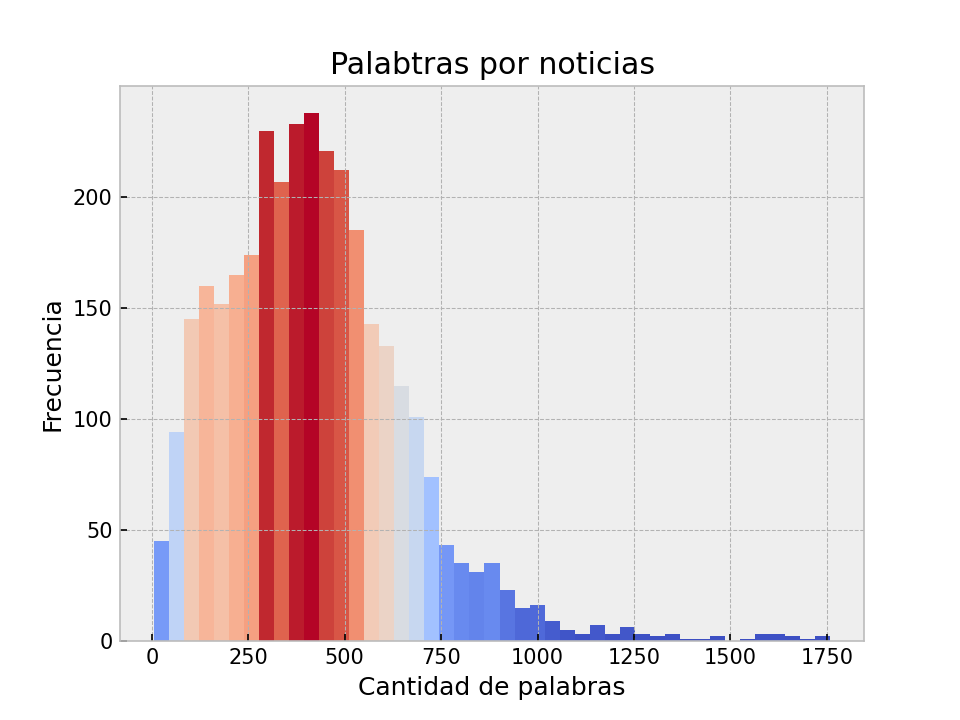

In [3]:
#=========> Plot de frecuencias chido
def PlotFrecuencias(df,colorpalet,x_lab,y_lab,title,style="bmh"):
    with plt.style.context(style):
        fig, axs = plt.subplots()
        N, bins, patches = axs.hist(df,bins=45)

        fracs = N / N.max()
        norm = colors.Normalize(fracs.min(), fracs.max())

        for thisfrac, thispatch in zip(fracs, patches):
            color = colorpalet(norm(thisfrac))
            thispatch.set_facecolor(color)

        axs.hist(df, bins=45, density=True)
        plt.title(title)
        plt.xlabel(x_lab)
        plt.ylabel(y_lab)

#=========> Se calculan los persentiles para que la grafica se vea chilo
quantile_low = cantidad_palabras.quantile(0.00)
quantile_high = cantidad_palabras.quantile(0.985)
contenido_primer_cuartil = cantidad_palabras[cantidad_palabras < quantile_low]
contenido_cuarto_cuartil = cantidad_palabras[cantidad_palabras > quantile_high ]

mascara_cuartil_central = lambda x: (x >= quantile_low)&( x <= quantile_high)
contenido_centro = cantidad_palabras[mascara_cuartil_central]


PlotFrecuencias(contenido_centro,plt.cm.coolwarm,
        "Cantidad de palabras", "Frecuencia",
        "Palabtras por noticias")

In [4]:
c = 0 
for con in muestra[cantidad_palabras < 20].Título:
    print(str(c) + " " + con)
    c+=1
c = 0 
print("---------------")
for con in muestra[cantidad_palabras < 20].Contenido:
    print(str(c) + " " + con)
    c+=1

0 Fotogalería. Inicio de la primera etapa de refinería Olmeca y mensaje por 4° Año del Triunfo Histórico, desde Paraíso, Tabasco
1 Fotogalería. Feria Aeroespacial México 2021
2 Fotogalería. VI Cumbre de la Comunidad de Estados Latinoamericanos y Caribeños (CELAC)
3 Fotogalería. Visita oficial a México del presidente de Guatemala, Alejandro Giammattei
4 Fotogalería. 200 Años de la Promulgación del Plan de Iguala y Día de la Bandera
5 Fotogalería. Visita oficial a México del presidente de Argentina, Alberto Fernández
6 Fotogalería. 2º Año de Gobierno 2018-2020
7 Fotogalería. Ofrenda homenaje a víctimas de la pandemia, desde Palacio Nacional
8 Fotogalería. 210 Aniversario del Grito de Independencia
9 Fotogalería Avión presidencial desde el hangar presidencial de la Fuerza Aérea Mexicana
10 Fotogalería Ceremonia del Primer Año de Gobierno 2018-2019
11 Fotogalería. Conmemoración del 109 Aniversario del inicio de la Revolución Mexicana
12 Fotogalería del 209 Aniversario de la Independencia d

Limpiado y otra graficacion

In [5]:
#############################################################################
# Nota, este codigo esta por mientras el tokenizado. Borrar esto despues...
stopword_es = nltk.corpus.stopwords.words('spanish')
def remove_stopwords(text):
    texto = text.split()
    text = [word for word in texto if word not in stopword_es]
    text_r = ' '.join(text)
    return text_r
corpus_entrenamiento['Titulo_ns'] = corpus_entrenamiento['Titulo'].apply(lambda x: remove_stopwords(x))
#----------------------------------------------------------------------------

-----------------------------------------------------
NameError           Traceback (most recent call last)
Cell In[96], line 9
      7     text_r = ' '.join(text)
      8     return text_r
----> 9 corpus_entrenamiento['Titulo_ns'] = corpus_entrenamiento['Titulo'].apply(lambda x: remove_stopwords(x))
     10 #----------------------------------------------------------------------------

NameError: name 'corpus_entrenamiento' is not defined


In [ ]:
frecuencias_del_corpus = TfidfVectorizer(
    ngram_range = (1,2),
    max_df=0.99999999999, 
    min_df=0
    )

corpus_vectorizado = frecuencias_del_corpus.fit_transform(corpus_entrenamiento.Titulo_ns) 

### Guardando frecuencias 
---
**C**omo en la mayoria de modelos, se busca que nuestro *conjunto de entrenamiento* pueda capturar las caracteristicas **mas significativas** y que el tamaño del *vector caracteristicas* sea **lo mas pequeño posible**

In [6]:
print(frecuencias_del_corpus.stop_words_)

matriz_cruda = corpus_vectorizado.toarray()
tokenizador = frecuencias_del_corpus.build_analyzer()
diccionario_vocabulario = frecuencias_del_corpus.vocabulary_

archivo_documentos ='documentos.csv'
archivo_diccionario='diccionario_token.csv'
archivo_tokens_por_documento = 'palabras_por_documento.csv'
archivo_matriz_cruda = 'matriz_cruda_frecuencias.csv'

##################################################################################
#Escribiendo el archivo 'informacion_documento' 
with open(archivo_documentos , 'w', encoding='utf-8') as archivo:
    archivo.write(f'id_documento,titulo,fecha\n')
    for elemento in corpus_entrenamiento.iloc:
        id_documento =elemento.name
        titulo = elemento.Titulo
        fecha = elemento.Fecha
        archivo.write(f'{id_documento},{titulo},{fecha}\n')

        
#_________________________________________________________________________________


##################################################################################'
# Guardando diccionario de los tokens
with open(archivo_diccionario, 'w', encoding='utf-8') as archivo:
    archivo.write(f'id_token,token\n')
    for (llave) in diccionario_vocabulario:
        archivo.write(f'{llave},{diccionario_vocabulario[llave]}\n')
#_________________________________________________________________________________ 


##################################################################################
#Escribiendo el archivo 'palabras_por_documento' 
with open(archivo_tokens_por_documento, 'w', encoding='utf-8') as archivo:
    archivo.write(f'id_documento,token,frecuencia\n')
    for elemento in corpus_entrenamiento.iloc:
        id_documento =elemento.name
        for token in (tokenizador(elemento.Titulo_ns)):
            id_token =diccionario_vocabulario[token] 
            frecuencia = matriz_cruda[id_documento][id_token]
            archivo.write(f'{id_documento},{token},{frecuencia}\n')
#_________________________________________________________________________________



##################################################################################
#Escribiendo el archivo 'matriz_cruda_frecuencias'
dataframe_corpus = pd.DataFrame(corpus_vectorizado.toarray())
dataframe_corpus.to_csv(archivo_matriz_cruda,index=False)
#Ejemplo_leer = pd.read_csv('frecuencias_del_corpus.csv')
#_________________________________________________________________________________ 

    
print('listo')

set()
listo


## Reduciendo dimencionalidad
---

**C**uando el vector de caracteristicas es muy grande se suele sufrir de *la maldición de la dimensionalidad* (o efecto Hughes), el cual es un problema conocido de la estadistica y probabilidadEn. Para mitigar estos efectos la solucion inmediata es reducir el numero de caracteristicas en nuestro vector. Los metodos mas populares son el **PCA** y usando una distribucion **chi2**.

In [ ]:
#If 0 < n_components < 1 and svd_solver == 'full', 
#select the number of components such that the amount of variance that 
#needs to be explained is greater than the percentage specified by n_components.
#svd_solver{‘auto’, ‘full’, ‘arpack’, ‘randomized’}

pca_corpus_entrenamiento = PCA(
    n_components= 0.70,
    svd_solver= 'full',
    whiten = False,
    random_state=576
    ) 
pca_corpus_entrenamiento.fit(corpus_vectorizado.toarray())
corpus_frecuencias_reducidas = corpus_frecuencias_reducidas.transform(corpus_vectorizado)

print('listo')

In [ ]:
print('f')

In [ ]:
print(corpus_frecuencias_reducidas)

### Guardando nuevas caracteristicas
---

## Aplicando Topic modeling

**L**as tecnicas de analizar grupos en aprendizaje automatico se conocen como **clustering** y el algoritmo mas popular de clustering es **K-means** el cual usa un enfoque basado en la *distancia* entre vectores de caracteristicas. 

Sin embargo para agrupar documentos existe un metodo muy popular que consiste en calcular dos *distribuciones de probabilidades*, Una de *topicos sobre tokens* y otra de *documentos sobre topicos*. Al algoritmo que calcula estas dos distribuciones se le llama **Latent Dirichlet Allocation**.

In [7]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=500,
    learning_method="online",
    learning_offset=50.0,
    random_state=876,
)
lda.fit()

feature = frecuencias_del_corpus.get_feature_names()
for ind, topic in enumerate(lda.components_):
    print('Top 50 words in topic {}'.format(ind))
    print('-'*25)
    topic_ordenado = topic.argsort()[::-1]
    top_50 = topic_ordenado[:50]
    print([feature[i] for i in top_50] , '\n\n')

NameError: name 'n_components' is not defined

### Guardando entropia del topic modeling

## Evaluacion empirica
---